In [1]:
# General imports
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import normalized_mutual_info_score 
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans2

#### Import Data

In [2]:
#####################
# KDD Dataset
# First column is the BLOCK ID (class label), BLOCK IDs are integers running from 1 to 303 with 153 unique values (k)
# Second column is the ELEMENT ID (sample number), unique numbers, not ordered
# Third column is the class of the example. Homologous proteins = 1, non-homologous proteins = 0
data = pd.read_csv('bio_train.csv',skiprows=0).to_numpy(dtype='object')

#####################
# Toy Dataset
toy_data = np.genfromtxt('dataset1_noCluster7.csv', delimiter = ',')[1:]
toy_data_features = toy_data[:,:2]
toy_data_labels = toy_data[:,-1]

# preprocess toy dataset
scaler = StandardScaler()
toy_data_features = scaler.fit_transform(toy_data_features)

#plt.scatter(toy_data_features[:,0], toy_data_features[:,1], c = toy_data_labels)
#plt.show()

#### Data Preprocessing

In [3]:
# Shuffle, split into labels/features and normalize data
def process_data(data, scale=False):
    # Shuffle
    shuffle = np.random.permutation(len(data))
    data = data[shuffle]
    
    # Split
    block_ids = data[:,0]
    element_ids = data[:,1]
    homology = data[:,2]
    features = data[:,3:]
    
    if scale:
        # Normalize the features
        scaler = StandardScaler()
        features = scaler.fit_transform(features)
    
    return block_ids, element_ids, features

In [4]:
# preprocess the data
block_ids, element_ids, features = process_data(data, scale=True)
features = features.astype(np.float64) # only important if no normalization is done

In [5]:
# Scipy Kmeans2 on kdd dataset for comparision
centroid, labels = kmeans2(features, k=153)

NMI_score = normalized_mutual_info_score(block_ids, labels)
print(NMI_score)


C:\Users\user\anaconda3\lib\site-packages\scipy\cluster\vq.py:607: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


0.1854906973412045


0.8376895750646733


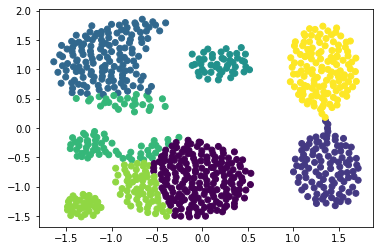

In [6]:
# Scipy Kmeans2 on toy dataset for comparision
centroid, labels = kmeans2(toy_data_features, k=7, iter=10)

NMI_score = normalized_mutual_info_score(toy_data_labels, labels)
print(NMI_score)

plt.scatter(toy_data_features[:,0], toy_data_features[:,1], c = labels)
plt.show()

### Task 1 - Lloyds Algorithm

In [7]:
# if the functions receives the true labels as a parameter, it calculates the NMI after avery 10 iterations

def lloyds(data, k=153, true_labels=[]):
    # Number of samples and features of the dataset
    
    n_samples, n_features = np.shape(data)
    
    # Pick k random points from data to be the initial cluster centers (eventually use kmeans+ here?)
    #rand_nums = np.random.randint(0,n_samples,k)
    #cluster_means = data[rand_nums]
    
    # pick the first k points as initial cluster means
    cluster_means = np.copy(data[:k])
    
    
    #kmeans++
    #cluster_means = kmeans_plus_initialization(data, k)
    
    old_means = np.zeros([k, n_features])
    counter = 0
    assign_time = 0
    
    while (old_means != cluster_means).any():
    
        counter += 1
        old_means = np.copy(cluster_means)
        
        # avoiding endless loop
        if counter == 1000:
            break
       
        
        ############# beginning of Assign step
        # measure assingment runtime
        start_assign = time.perf_counter()
        
        distance_matrix = cdist(data, cluster_means, metric='sqeuclidean')
        cluster_labels = np.argmin(distance_matrix, axis=1)
        
        end_assign = time.perf_counter()
        assign_time += end_assign - start_assign
        ############# end of Assign step
        
        # printing progress
        if counter % 10 == 0: 
            print("iteration: ",counter)
            if len(true_labels) != 0:
                NMI_score = normalized_mutual_info_score(true_labels, cluster_labels)
                print("current NMI:", NMI_score)
            print('assign step runtime: '+str(end_assign - start_assign)) 
    
    
        ############# beginning of Update step
        for j in range(k):
            
            idcs = np.where(cluster_labels == j)[0]
            cluster_size = len(idcs)
            
            if cluster_size > 0:
                cluster_sum = np.sum(data[idcs], axis=0)
                cluster_means[j] = cluster_sum/cluster_size
            
            
    assign_time /= counter        
    print('Average assign step runtime: '+str(assign_time))    
    print('KMeans converged in '+str(counter)+' iterations.')
    return cluster_labels, cluster_means

# only for trying out. Not required and currently not used by the algorithm
def kmeans_plus_initialization(data, k):
    no_samples = len(data)
    
    cluster_means = np.zeros((k,len(data[0])))
    cluster_means[0] = data[np.random.randint(0,no_samples)]
    
    for i in range(1,k):
        distances = cdist(data,cluster_means, metric='sqeuclidean')
        idx = np.argmax(np.min(distances, axis = 1))
        cluster_means[i] = data[idx]

    return cluster_means

In [8]:
# clustering the KDD Dataset
labels, centers = lloyds(features, true_labels = block_ids)

iteration:  10
current NMI: 0.1872461796885601
assign step runtime: 0.8797117000000014
iteration:  20
current NMI: 0.1876671087117651
assign step runtime: 0.8531227000000001
iteration:  30
current NMI: 0.18827032555117373
assign step runtime: 0.8517653000000038
iteration:  40
current NMI: 0.1885331040440957
assign step runtime: 0.851909599999999
iteration:  50
current NMI: 0.18851576529878478
assign step runtime: 0.8545645000000093
iteration:  60
current NMI: 0.18852186194132411
assign step runtime: 0.8559941000000038
iteration:  70
current NMI: 0.1886609000528899
assign step runtime: 0.8582609000000048
iteration:  80
current NMI: 0.18878739165807323
assign step runtime: 0.8587784999999997
iteration:  90
current NMI: 0.18911515897991227
assign step runtime: 0.8549274000000082
iteration:  100
current NMI: 0.1891752051223918
assign step runtime: 0.857588700000008
iteration:  110
current NMI: 0.18910304632615274
assign step runtime: 0.8530920999999978
iteration:  120
current NMI: 0.189206

In [11]:
NMI_score = normalized_mutual_info_score(block_ids, labels)
print(NMI_score)

0.19001230339497727


iteration:  10
assign step runtime: 4.0500000068277586e-05
iteration:  20
assign step runtime: 3.919999994650425e-05
Average assign step runtime: 6.675714285263114e-05
KMeans converged in 21 iterations.
Runtime: 0.00558509999996204
0.8418833655707196


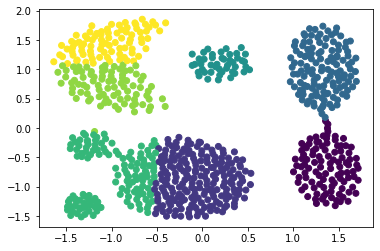

In [12]:
# run algorithm with the toy dataset
start = time.perf_counter()
toy_labels, toy_centers = lloyds(toy_data_features, k=7)
stop = time.perf_counter()
print("Runtime:", stop-start)
NMI_score = normalized_mutual_info_score(toy_data_labels, toy_labels)
print(NMI_score)

plt.scatter(toy_data_features[:,0], toy_data_features[:,1], c = toy_labels)
plt.show()

### Task 2 - LSH + Kmeans

In [13]:
# This class defines a given number of hash functions. 

# not finished, just playing around, hello Jakob

class hash_functions:
    def __init__(self, no_functions, no_buckets, no_features):
        self.no_functions = no_functions
        self.no_buckets = no_buckets
        self.no_features = no_features
        
        # parameters of the hash functions
        self.b = np.zeros(no_functions) # vector
        self.a = np.random.normal(loc=0.0, scale=1.0, size=(no_features, no_functions)) # matrix
        
    def sample_hash_values(self, data):
        
        self.w = np.zeros(self.no_functions)
        hash_values = np.dot(data, self.a) + self.b
        
        # This for loop goes over each column of the hash_values (each hash function) and computes 
        # the bucket size (w) for the given no_buckets parameter; thereafter it uses these values
        # to complete the (a*p + b)/w hash values definition
        
        # w has to be known apriori and is only possible to derive using part of the actual hashing process
        # a more visually pleasing version of this would be to calculate w using data during the initialization
        # and use one single hashing function for both samples and clusters, but then we have to recompute a 
        # lot of calculation in the hashing - namely (a*p + b), which is used in the w computation
        
        min_vals = np.min(hash_values, axis = 0)
        max_vals = np.max(hash_values, axis = 0)
    
        self.w = (max_vals-min_vals)/(self.no_buckets - 1)
        hash_values = np.floor(hash_values/self.w[np.newaxis,:])
        
        return hash_values
    
    def cluster_hash_values(self, data):
        return np.floor((np.dot(data, self.a) + self.b) / self.w)
        

In [14]:
# hashing with the idea from L04, slide 25.

class Hashing:
    def __init__(self, no_functions, no_features, no_init_buckets, no_final_buckets):

        self.no_functions = no_functions
        self.no_features = no_features
        # number of buckets for the initial hash functions applied on each feature vector
        self.no_init_buckets = no_init_buckets
        # number of buckets for the hash functions which are applied to each of the "initial" hash functions as a replacement to the AND-comparision 
        self.no_final_buckets = no_final_buckets   
        
        self.initialize_hash_functions()
        self.initialize_AND_hash_functions()
  
    def initialize_hash_functions(self):
        # initialize the hash funtions which are applied on each feature vector
        self.b = np.zeros(self.no_functions) # vector
        self.a = np.random.normal(loc=0.0, scale=1.0, size=(self.no_features, self.no_functions)) # matrix
    
    def initialize_AND_hash_functions(self):
        # initialize the hash funtions which are applied on the "initial" hash functions as a replacement of the AND comparisions        
        
        # according to the post from the prof x and y should be between 1 and no_final_buckets
        self.x = np.random.choice(np.array(range(1,self.no_final_buckets+1)), size=self.no_functions)
        self.y = np.random.choice(np.array(range(1,self.no_final_buckets+1)), size=self.no_functions)
        
        # I am not so sure which value to choose for p. Should it be a large prime number 
        # or should it just be any number bigger than no_final_buckets? 
        self.p = self.no_final_buckets * 2 + 1
        
    def get_hash_functions(self):
        # just for diagnosis reasons to be able to look at the parameters of the functions
        return (self.a,self.b,self.x,self.y,self.p)
        
    def initial_hash_value_calculation(self, data, n_and):
        # calculates the bucket width w 
        # and the parameters b such that the bucket indices are all positive (starting at 0)
        
        # check if n_and is valid
        if (self.no_functions % n_and) != 0:
            raise Exception("no_functions must be divisible by n_and")
        
        # initialize bucket width w
        self.w = np.zeros(self.no_functions)
        hash_values = np.dot(data, self.a) + self.b
        min_vals = np.min(hash_values, axis = 0)
        max_vals = np.max(hash_values, axis = 0)
        self.w = (max_vals-min_vals)/(self.no_init_buckets - 1)
        
        # initialize shift b
        # b equals minimal values of the projected vectors, only if the minimal value is negativ. Otherwise b is zero. 
        self.b = -min_vals * (min_vals < 0)
        
        # first hash functions applied on the feature vectors
        hash_values = np.floor(np.dot(data, self.a) + self.b / self.w)
        
        # additional hash function (AND opertation) from L04, slide 25
        hash_values = ((self.x * hash_values + self.y) % self.p) % self.no_final_buckets
        
        # sum up the n_and hash values and distribute them into no_final_buckets buckets
        AND_hash_values = np.add.reduceat(hash_values,range(0,self.no_functions,n_and), axis = 1) % self.no_final_buckets
        
        return AND_hash_values
    
    
    def hash_value_calculation(self, data, n_and):
        # calculates the hash values for the cluster centers in each iteration. 
        # initial_hash_value_calculation must have been called on the features before this function.
        
    
        # first hash function applied on the feature vectors
        hash_values = np.floor(np.dot(data, self.a) + self.b / self.w)
        
        # additional hash function (AND opertation)from L04, slide 25
        hash_values = ((self.x * hash_values + self.y) % self.p) % self.no_final_buckets
        
        # sum up the n_and hash values and distribute them into no_final_buckets buckets
        AND_hash_values = np.add.reduceat(hash_values,range(0,self.no_functions,n_and), axis = 1) % self.no_final_buckets
        
        return AND_hash_values       
        
    

In [15]:
# WORK IN PROGRESS
# this functions can be used with both approaches
# 1) with the hash_functions class 
# 2) with the Hashing class (approach from L04, slide 25). 
# you have to uncomment/comment the respective sections in the code to change which approach is used. 
# there are two parts of the code which you have to uncomment/comment. One before the while loop and one inside the while loop.
# The rest of the code doesnt need to be changed.
# in case of the second approach the parameter no_buckets refers to the no_final_buckets.

# if the functions receives the true labels as a parameter, it calculates the NMI after avery 10 iterations

def lloyds_LSH(data, k=153, n_and=2, n_or=2, no_buckets=10, no_initial_buckets = 100, true_labels=[]):
    
    # Number of samples and features of the dataset
    n_samples, n_features = np.shape(data)
    no_functions = n_and * n_or
    
    print("Start initialization ...")
    
    # Pick the first k points as initial cluster means
    cluster_means = np.copy(data[:k])
    
    
    # 1) first approach using the hash_functions class
    ########################################################################
    # Initialize hash functions
    hash_funcs = hash_functions(no_functions, no_buckets, n_features)
    # Hash samples
    sample_hashes = hash_funcs.sample_hash_values(data).reshape(n_samples, n_and, n_or)
    ########################################################################
    
    
    
    # 2) hashing with the idea from L04, slide 25. 
    ########################################################################
    # Initialize Hashing
    #myHashing = Hashing(n_and * n_or, n_features, no_initial_buckets, no_buckets)
    
    # Hash samples
    #sample_hashes = myHashing.initial_hash_value_calculation(data, n_and)
    ########################################################################
    

    old_means = np.zeros([k, n_features])
    counter = 0
    assign_time = 0
    print("Start iterations ...")
    while (old_means != cluster_means).any():
    
        counter += 1
        
        # avoiding endless loop
        if counter == 1000:
            break
              
        
        old_means = np.copy(cluster_means)
        cluster_labels = np.zeros(n_samples) - 1
        total_preassigned_samples = 0
        
        # measure runtime of and/or hashing 
        start_and_or = time.perf_counter()
        
        # 1) first approach using the hash_functions class
        ########################################################################
        # Hash cluster centers
        cluster_hashes = hash_funcs.cluster_hash_values(cluster_means).reshape(k, n_and, n_or)
        
        # note: if a sample has a collision with two cluster centers it will get assigned to the one with the higher cluster index
        for j in range(k):
            collision_idcs = np.where((sample_hashes == cluster_hashes[j]).all(axis=1).any(axis=1))[0]
            total_preassigned_samples += collision_idcs.size
            if(collision_idcs.size != 0):
                cluster_labels[collision_idcs] = j
        ########################################################################
        
        
        
        # 2) hashing with the idea from L04, slide 25.
        ########################################################################        
        # Hash cluster centers
        #cluster_hashes = myHashing.hash_value_calculation(cluster_means, n_and)
        
        # note: if a sample has a collision with two cluster centers it will get assigned to the one with the higher cluster index
        #for j in range(k):
        #    collision_idcs = np.where((sample_hashes == cluster_hashes[j]).any(axis=1))[0]
        #    total_preassigned_samples += collision_idcs.size
        #    cluster_labels[collision_idcs] = j
        ########################################################################
        
        end_and_or = time.perf_counter()
        

        # measure runtime of distance computations
        start_dist = time.perf_counter()
        
        # Compute distance for unassigned samples
        unassig = np.where(cluster_labels == -1)[0]
        distance_matrix = cdist(data[unassig],cluster_means, metric='sqeuclidean')
        cluster_labels[unassig] = np.argmin(distance_matrix, axis=1)
        
        end_dist = time.perf_counter()
        #print("Distance computation time: ", end_dist-start_dist)
#        assign_time += (end_dist-start_dist)
        
    
        # printing diagnostics
        if counter==1:
            if len(true_labels) != 0:
                NMI_score = normalized_mutual_info_score(true_labels, cluster_labels)
                print("NMI after 1st iteration: ", NMI_score)
    
        if (counter % 10) == 0:
            print("iteration: ",counter)
            print("and-or calculation runtime (last iteration): ", end_and_or-start_and_or)
            print("distance computation time (last iteration): ", end_dist-start_dist)
            print("number of preassigned samples by hashing: ", total_preassigned_samples)
            if len(true_labels) != 0:
                NMI_score = normalized_mutual_info_score(true_labels, cluster_labels)
                print("current NMI: ", NMI_score)
            
        
        ############# Update step
        for j in range(k):
            
            idcs = np.where(cluster_labels == j)[0]
            cluster_size = len(idcs)
            
            if cluster_size > 0:
                cluster_sum = np.sum(data[idcs], axis=0)
                cluster_means[j] = cluster_sum/cluster_size
        
        
    assign_time /= counter        
    #print('Average assign step runtime: '+str(assign_time))    
    print('KMeans converged in '+str(counter)+' iterations.')
    return cluster_labels, cluster_means

In [16]:
# clustering the KDD Dataset
labels, centers = lloyds_LSH(features, k = 153, n_and = 4, n_or = 4, no_buckets=100, no_initial_buckets = 5, true_labels=block_ids)

NMI_score = normalized_mutual_info_score(block_ids, labels)
print("NMI: ", NMI_score)

Start initialization ...
Start iterations ...
NMI after 1st iteration:  0.060551479939063964
iteration:  10
and-or calculation runtime (last iteration):  3.627199399999995
distance computation time (last iteration):  0.22239300000001094
number of preassigned samples by hashing:  555903
current NMI:  0.07645730274231673
iteration:  20
and-or calculation runtime (last iteration):  3.6141607999999223
distance computation time (last iteration):  0.22374220000006062
number of preassigned samples by hashing:  558559
current NMI:  0.07802228197130451
iteration:  30
and-or calculation runtime (last iteration):  3.6204440000000204
distance computation time (last iteration):  0.21572989999992842
number of preassigned samples by hashing:  551145
current NMI:  0.07677716402687983
iteration:  40
and-or calculation runtime (last iteration):  3.6177057000001014
distance computation time (last iteration):  0.21684770000001663
number of preassigned samples by hashing:  549176
current NMI:  0.0771865311

iteration:  370
and-or calculation runtime (last iteration):  3.8604411999999684
distance computation time (last iteration):  0.2116731000000982
number of preassigned samples by hashing:  537616
current NMI:  0.07620240058872252
iteration:  380
and-or calculation runtime (last iteration):  3.6964688999996724
distance computation time (last iteration):  0.21306890000005296
number of preassigned samples by hashing:  538098
current NMI:  0.07619885519471072
iteration:  390
and-or calculation runtime (last iteration):  3.6807583999998315
distance computation time (last iteration):  0.21347090000017488
number of preassigned samples by hashing:  538968
current NMI:  0.07593479901066388
iteration:  400
and-or calculation runtime (last iteration):  3.612510899999961
distance computation time (last iteration):  0.2076108999999633
number of preassigned samples by hashing:  541508
current NMI:  0.07575380404559534
iteration:  410
and-or calculation runtime (last iteration):  3.6505903000002036
di

KeyboardInterrupt: 

Start initialization ...
Start iterations ...
iteration:  10
and-or calculation runtime (last iteration):  0.002779200000077253
distance computation time (last iteration):  9.369999997943523e-05
number of preassigned samples by hashing:  0
iteration:  20
and-or calculation runtime (last iteration):  0.0020091000001229986
distance computation time (last iteration):  6.419999999707215e-05
number of preassigned samples by hashing:  0
KMeans converged in 21 iterations.
Runtime: 0.05674750000025597
NMI:  0.8418833655707196


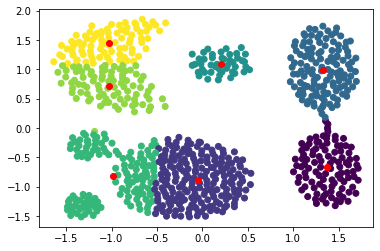

In [17]:
# run LSH with the toy dataset
start = time.perf_counter()
toy_labels, toy_centers = lloyds_LSH(toy_data_features, k=7,  n_and = 16, n_or = 6, no_buckets = 7000,  no_initial_buckets = 10)
stop = time.perf_counter()
print("Runtime:",stop-start)
NMI_score = normalized_mutual_info_score(toy_data_labels, toy_labels)
print("NMI: ", NMI_score)



plt.scatter(toy_data_features[:,0], toy_data_features[:,1], c = toy_labels)
plt.scatter(toy_centers[:,0],toy_centers[:,1] , c = 'red')
plt.show()

In [ ]:
# grid search for the toy dataset
# uncomment the "printing diagnostics" section in the algorithm before
n_and_sequence = [2,4,16]
n_or_sequence = [2,4,16]
no_init_buckets_sequence = [10, 100, 1000, 10000]
no_final_buckets_sequence = [10, 100, 1000, 10000]
for n_and in n_and_sequence:
    for n_or in n_or_sequence:
        for no_init_buckets in no_init_buckets_sequence:
            for no_final_buckets in no_final_buckets_sequence:
                NMI_score_mean = 0
                for i in range(5):
                    toy_labels, toy_centers = lloyds_LSH(toy_data_features, k=7,  n_and = n_and, n_or = n_or, no_buckets=no_final_buckets, no_initial_buckets = no_init_buckets )
                    NMI_score_mean += normalized_mutual_info_score(toy_data_labels, toy_labels)
                NMI_score_mean /=5
                print(n_and,n_or,no_init_buckets,no_final_buckets, "Score: ", NMI_score_mean)

### Task 3 - Coresets + Kmeans

In [18]:
# Algorithm 1 from the linked paper
def coreset(data, m):
    # Data length
    n = len(data)
    
    # Data mean stored as an [features, 1] array
    mu = [np.mean(data, axis=0)]
    
    # Distance squared array of the sample to the data mean
    dist_array = cdist(data, mu, metric='sqeuclidean')
    
    # Total distance squared sum
    total_dist = np.sum(dist_array)
    
    # Array of sampling probabilities
    q_x = np.zeros(n)
    
    # Fill q_x with the given relation
    for i in range(n):
        q_x[i] = (1/n + dist_array[i]/total_dist)/2
    
    # Array of weights
    w_x = 1/(m*q_x)
    
    # Using q_x, sample k indices with the probability q_x, without replacements
    indices = np.random.choice(np.arange(n), m, replace=False, p=q_x)
    
    # Use the sampled indices to return the coreset samples and their corresponding weights
    return data[indices], w_x[indices]

# Theorem 2, section 5 of the linked paper
def m_val(d, k, delta, epsilon):
    
    # With this choice of the constant c and the fact, that the term log(1/delta) is significantly smaller 
    # than the dk * log(k) term (for the d,k of the KDD dataset), the whole relation for m effectively reduces to 1/epsilon^2
    c = 1/(d * k * np.log(k)) 
    
    # Here instead of log(1/delta) we use the equivalent form of -log(delta)
    m = c * (d * k * np.log(k) - np.log(delta)) / epsilon**2
    
    # The computated m value, as mentioned previously, is approximately 1/epsilon^2 for the given choice of c
    return int(m)

In [19]:
# Pick 4 epsilon values
eps_vals = [0.05, 0.025, 0.01, 0.005]

In [20]:
# Compute 4 m values using the epsilon array with a fixed value of delta = 0.01
# Remember, delta does not influence the value of m for our dataset, so changing it would produce close to indentical results
m_vals = []
for epsilon in eps_vals:
    
    # d = 74 features, k = 153 clusters
    m_vals.append(m_val(74, 153, 0.01, epsilon))

In [21]:
# Number of iterations for the benchmarking
n_iter = 10

# Initialize array for storing the runtime, iterations and NMI scores
result_array = np.zeros([n_iter, len(m_vals), 3])

for i in range(n_iter):
    for j in range(len(m_vals)):
        # Start timer
        start_coreset = time.perf_counter()

        # Get coreset for given m
        kdd_core, kdd_weights = coreset(features, int(m_vals[j]))

        # Perform kmeans
        kmeans = KMeans(n_clusters=153, random_state=0).fit(kdd_core, sample_weight = kdd_weights)

        # Obtain predicted labels
        kdd_labels = kmeans.predict(features)

        # End timer
        end_coreset = time.perf_counter()

        # Store runtime, iterations and NMI score
        result_array[i][j][0] = end_coreset-start_coreset
        result_array[i][j][1] = kmeans.n_iter_
        result_array[i][j][2] = normalized_mutual_info_score(kdd_labels, block_ids)

In [85]:
# Compute results averaged over the 10 runs
results_mean = np.mean(result_array, axis=0)

# Extract the variance from the NMI scores
results_var = np.zeros(4)
for i in range(4):
    results_var[i] = np.var(result_array[:,i][:,2])

# Join with m values array
results_table = np.concatenate((np.array([m_vals]).T, results_mean, np.array([results_var]).T), axis=1)

# Transform to pandas dataframe with appropriate column names
results_pandas = pd.DataFrame(results_table, columns = ['m', 'runtime[s]', 'iterations', 'NMI score', 'Variance'])

In [86]:
# Display results
results_pandas

,m,runtime[s],iterations,NMI score,Variance
0,400.0,0.838974,4.8,0.148711,2.015825e-05
1,1600.0,1.238545,13.6,0.166433,3.399461e-06
2,10000.0,5.988849,44.6,0.180573,4.640067e-07
3,40003.0,44.782066,124.7,0.187579,8.155013e-07
